In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 1. 데이터 전처리 및 Data Loader 정의

- 데이터 전처리 함수 정의

In [2]:
class NEWSdata(Dataset):
    def __init__(self, x_path, y_path):
        super().__init__()
        self.x = np.load(x_path)
        self.y = np.load(y_path)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        y = torch.LongTensor(self.y)[idx]
        return x,y
    

- Data Loader 정의

In [3]:
bsize=512
train_set = NEWSdata('./NEWS_x_train.npy','./NEWS_y_train.npy')
train_dataloader = DataLoader(train_set, batch_size=bsize)
test_set = NEWSdata('./NEWS_x_test.npy','./NEWS_y_test.npy')
test_dataloader = DataLoader(test_set, batch_size=bsize)

In [4]:
for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([512, 10000])
Shape of y: torch.Size([512]) torch.int64


## 2. 모델 정의

In [5]:
class NEWSClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10000, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 46),
            nn.Softmax(dim=1)
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
model = NEWSClassifier().to(device)
print(model)

NEWSClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=46, bias=True)
    (5): Softmax(dim=1)
  )
)


- [손실함수](https://pytorch.org/docs/stable/nn.html#loss-functions)와 [옵티마이저](https://pytorch.org/docs/stable/optim.html) 정의

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

## 3. 모델 학습

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        # 손실 점수 계산
        pred = model(x)
        loss = loss_fn(pred, y)
        # 기울기 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#        if batch % 100 == 0:
#            loss, current = loss.item(), (batch + 1) * len(x)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

- 성능 검증 함수 정의

In [9]:
def test(dataloader, model, loss_fn, t='Test'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(t, f"Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct*100, test_loss

- 학습

In [10]:
epochs = 30
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    train_history.append(test(train_dataloader, model, loss_fn,'Train'))
    test_history.append(test(test_dataloader, model, loss_fn,'Test'))
print("Done!")

Epoch 1
-------------------------------


Train Error: 
 Accuracy: 54.4%, Avg loss: 3.326634 

Test Error: 
 Accuracy: 54.1%, Avg loss: 3.332963 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 55.3%, Avg loss: 3.313654 

Test Error: 
 Accuracy: 54.4%, Avg loss: 3.325818 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 64.1%, Avg loss: 3.238673 

Test Error: 
 Accuracy: 62.2%, Avg loss: 3.264106 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 65.3%, Avg loss: 3.214724 

Test Error: 
 Accuracy: 63.4%, Avg loss: 3.243910 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 65.5%, Avg loss: 3.210277 

Test Error: 
 Accuracy: 63.4%, Avg loss: 3.241439 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 65.7%, Avg loss: 3.206681 

Test Error: 
 Accuracy: 63.3%, Avg loss: 3.239627 

Epoch 7
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss: 3.170758 

Test Error: 
 Accuracy: 66.3%, Avg loss: 3.220019 

Epoch 8
-----------------

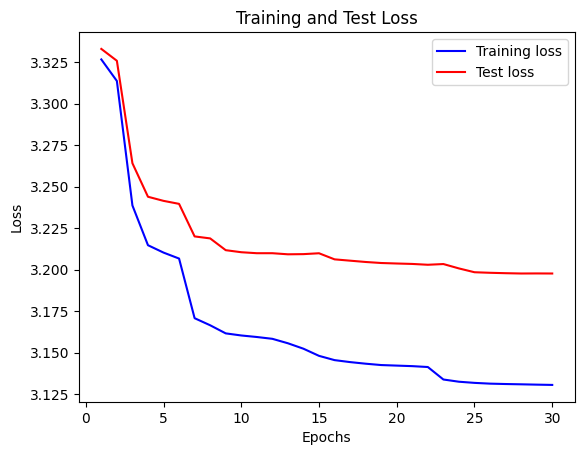

In [11]:
tr_loss = [i[1] for i in train_history]
te_loss = [i[1] for i in test_history]
epochs= range(1, len(tr_loss) + 1)
plt.plot(epochs, tr_loss, 'blue', label='Training loss')
plt.plot(epochs, te_loss, 'red', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

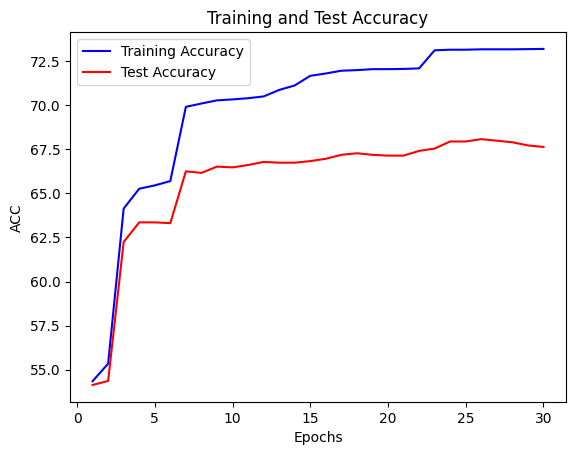

In [12]:
tr_acc = [i[0] for i in train_history]
te_acc = [i[0] for i in test_history]
epochs= range(1, len(tr_acc) + 1)
plt.plot(epochs, tr_acc, 'blue', label='Training Accuracy')
plt.plot(epochs, te_acc, 'red', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend();

## 4. 작은 중간층의 영향은?

In [13]:
class NEWSClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10000, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
            nn.ReLU(),
            nn.Linear(4, 46),
            nn.Softmax(dim=1)
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NEWSClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
epochs = 30
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    train_history.append(test(train_dataloader, model, loss_fn,'Train'))
    test_history.append(test(test_dataloader, model, loss_fn,'Test'))
print("Done!")


Epoch 1
-------------------------------
Train Error: 
 Accuracy: 49.2%, Avg loss: 3.540821 

Test Error: 
 Accuracy: 48.9%, Avg loss: 3.552290 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 54.4%, Avg loss: 3.354031 

Test Error: 
 Accuracy: 53.9%, Avg loss: 3.363903 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 55.0%, Avg loss: 3.327679 

Test Error: 
 Accuracy: 54.2%, Avg loss: 3.338850 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 55.4%, Avg loss: 3.317572 

Test Error: 
 Accuracy: 54.6%, Avg loss: 3.330410 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 55.6%, Avg loss: 3.312622 

Test Error: 
 Accuracy: 54.5%, Avg loss: 3.326768 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 55.7%, Avg loss: 3.310403 

Test Error: 
 Accuracy: 54.4%, Avg loss: 3.325839 

Epoch 7
-------------------------------
Train Error: 
 Accuracy: 55.8%, Avg loss: 3.308072 

Test Error: 
 Accuracy: 54.6%, Avg lo

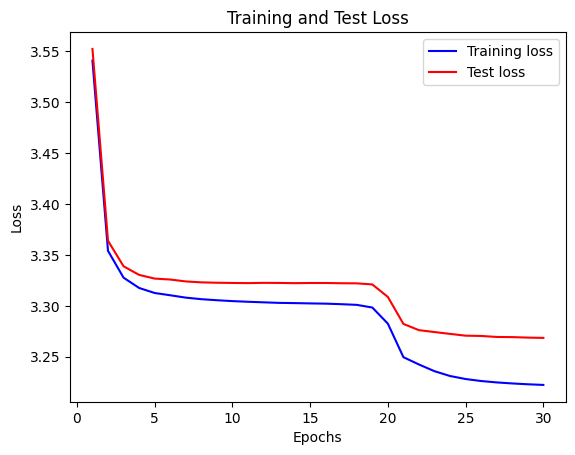

In [14]:
tr_loss = [i[1] for i in train_history]
te_loss = [i[1] for i in test_history]
epochs= range(1, len(tr_loss) + 1)
plt.plot(epochs, tr_loss, 'blue', label='Training loss')
plt.plot(epochs, te_loss, 'red', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

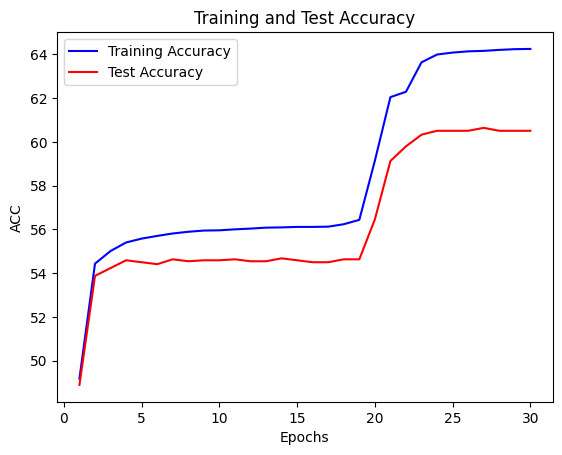

In [15]:
tr_acc = [i[0] for i in train_history]
te_acc = [i[0] for i in test_history]
epochs= range(1, len(tr_acc) + 1)
plt.plot(epochs, tr_acc, 'blue', label='Training Accuracy')
plt.plot(epochs, te_acc, 'red', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend();